**Variational Auto encoder**

## Import library

In [31]:
## import library
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import plot_model

Below is model architecture

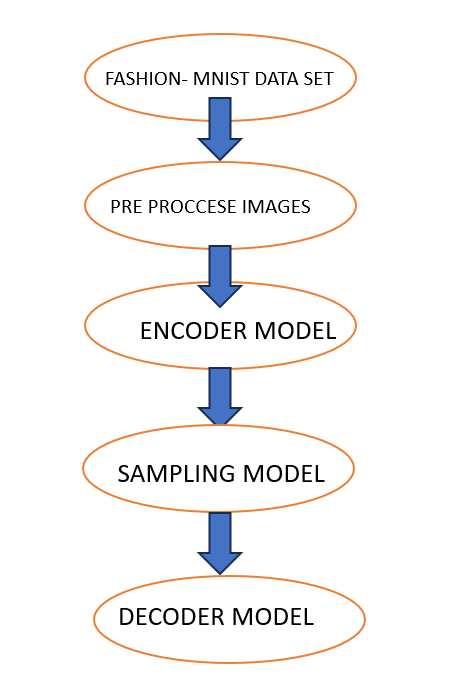

We will use fashion Mnist Data set to train a VAE model

In [32]:
### Load Fashion MNIST data
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

*pre-process*


1.   Normalize image into range of 0 to 1
2.   Reshape imgae into 28 ,28 ,1 ( although Mnist already in that shape)



In [33]:
#### Pre-proccese Images
x_train = np.reshape(x_train, (-1, 28, 28, 1)).astype('float32') / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1)).astype('float32') / 255.0

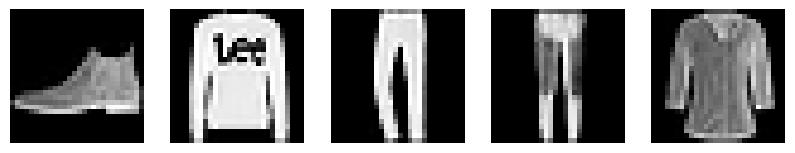

In [34]:
#### Display some image
def display_images(images, n=5):
    plt.figure(figsize=(10, 5))
    for i in range(n):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
display_images(x_test, n=5)

# **Encoder**

### Summary of the Encoder Model

1. **Input Layer**:
   - The encoder takes input images of shape **(28, 28, 1)**, which corresponds to 28x28 grayscale images.

2. **First Convolutional Layer**:
   - **Layer Type**: `Conv2D`
   - **Filters**: 32
   - **Kernel Size**: 3x3
   - **Activation Function**: ReLU
   - **Padding**: Same (maintains input dimensions)

3. **First Max Pooling Layer**:
   - **Layer Type**: `MaxPooling2D`
   - Reduces the spatial dimensions of the feature maps, effectively down-sampling.

4. **Second Convolutional Layer**:
   - **Layer Type**: `Conv2D`
   - **Filters**: 64
   - **Kernel Size**: 3x3
   - **Activation Function**: ReLU
   - **Padding**: Same (maintains input dimensions)

5. **Second Max Pooling Layer**:
   - **Layer Type**: `MaxPooling2D`
   - Further reduces the spatial dimensions, extracting more abstract features.

6. **Flattening Layer**:
   - **Layer Type**: `Flatten`
   - Converts the 2D feature maps into a 1D vector, preparing for the dense layers.

7. **Output**:
   - The encoder will eventually produce two outputs representing the **mean** and **log variance** of the latent space distribution for the VAE.



In [35]:
## Dimensionality of the latent space (Taken 2 to visulize , can be taken more like 5 ,10)
latent_dim = 2

In [36]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)

In [37]:
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)

In [11]:
### Define encoder model
#encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")

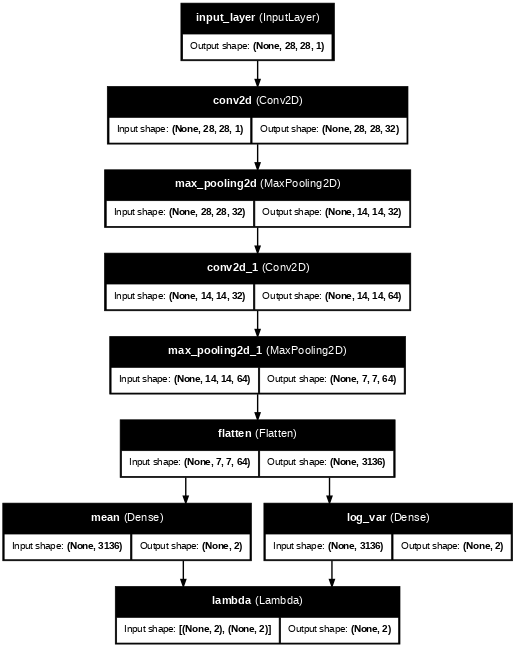

In [12]:
# Visualize the Encoder model
#plot_model(encoder, to_file='encoder_model.png', show_shapes=True, show_layer_names=True,dpi=50)

# **Sampling Function**
### Definition of the Sampling Function

The sampling function main job is to create latent space representations using the mean and log variance that the encoder has learned. This allows us to generate new data points by introducing some randomness based on the learned distribution. Essentially, it takes the average (mean) and how spread out the data is (log variance) to produce new samples from the latent space.


### Step-by-Step Explanation of the Sampling Function

#### Function Definition:
- The function is defined as `sampling(args)`, where `args` is expected to be a list containing two elements: `mean` and `log_var`.
- These values come from the encoder's output and represent the mean and log variance of the latent space distribution.

#### Unpacking Arguments:
- The line `mean, log_var = args` unpacks the `mean` and `log_var` from the input arguments.
- Here, `mean` is the average of the latent space, and `log_var` indicates the spread of the distribution.

#### Generating Random Noise:
- The line `epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean))` generates random noise sampled from a standard normal distribution (mean = 0, variance = 1).
- The generated noise has the same shape as the `mean` tensor to ensure compatibility.

#### Sampling from the Distribution:
- The final line `return mean + tf.exp(0.5 * log_var) * epsilon` computes the sampled latent vector.
  
Here’s how it works:
1. `tf.exp(0.5 * log_var)` calculates the standard deviation of the distribution by exponentiating half of the log variance, which is crucial since variance must be a positive quantity.
2. The sampled latent vector is then obtained by adding the random noise (`epsilon`), scaled by the standard deviation, to the `mean`.
3. This process introduces variability, allowing for the generation of diverse samples from the learned distribution.


In [38]:
def sampling(args):
    mean, log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon

In [39]:
z = layers.Lambda(sampling)([mean, log_var])

# **DECODER**

### Decoder Model Explanation

The decoder model is responsible for reconstructing images from the latent space representations created by the encoder. Here’s a simple breakdown of its structure and function:

1. **Input Layer**:
   - The decoder starts with an input layer that accepts a latent vector. This vector is a compressed version of the information from the original image.

2. **Dense Layer**:
   - The latent vector is passed through a dense layer. This layer transforms the input into a larger vector that will be reshaped into a 3D format. The layer uses an activation function to add complexity to the model.

3. **Reshape Layer**:
   - After the dense layer, the output is reshaped into a three-dimensional format. This step prepares the data for further processing by creating a structured layout that includes width, height, and depth.

4. **Transposed Convolutional Layer**:
   - A transposed convolutional layer is applied next. This layer helps increase the size of the feature map while keeping important information intact. It applies an activation function to learn complex patterns from the data.

5. **Upsampling Layer**:
   - The model then upsamples the feature map. This layer doubles the dimensions of the feature map, making it larger and more detailed.

6. **Second Transposed Convolutional Layer**:
   - Another transposed convolutional layer is added to refine the upsampled feature map. This layer helps improve the quality of the generated image by learning more features.

7. **Second Upsampling Layer**:
   - Another upsampling layer follows, which again increases the dimensions of the feature map, preparing it for the final output layer.

8. **Output Layer**:
   - Finally, the model ends with a transposed convolutional layer that generates the output image. This layer ensures the pixel values are within a specific range suitable for image reconstruction.


In [40]:
#decoder
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

In [41]:
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

In [42]:
### Define encoder model
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")

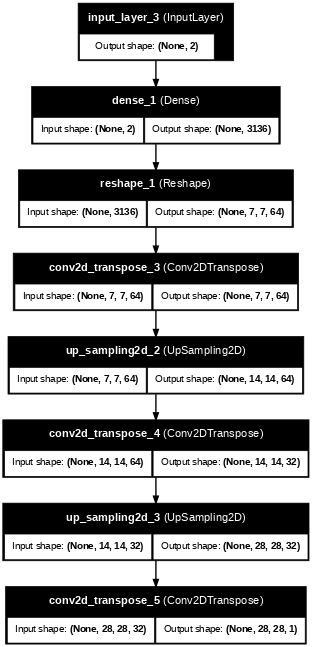

In [43]:
# Visualize the Decoder model
plot_model(decoder, to_file='decoder_model.png', show_shapes=True, show_layer_names=True,dpi=50)

# **Combine model**

In [44]:
vae = keras.Model(encoder_inputs, decoder(z), name="vae")

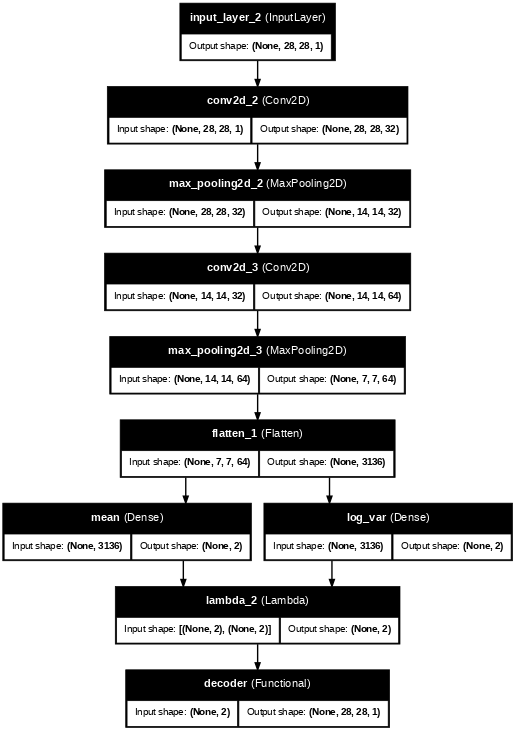

In [45]:
# Visualize the combined model
plot_model(vae, to_file='combined_model.png', show_shapes=True, show_layer_names=True,dpi=50)

Losse Function

Now , time is to define our losse function , which will be
Sum of KL divergance and MSE

### 1. Mean Squared Error (MSE) Loss

The Mean Squared Error (MSE) loss function is designed to evaluate the accuracy of the model's image reconstructions.

- **Function Inputs**:
  - **`y_true`**: This represents the original images that serve as the ground truth.
  - **`y_pred`**: This represents the reconstructed images produced by the model.

- **Calculation**:
  - The function computes the binary crossentropy between the true images (`y_true`) and the predicted images (`y_pred`).
  - This binary crossentropy quantifies the difference between the two sets of images, providing a measure of reconstruction accuracy.

- **Scaling**:
  - The resulting loss value is multiplied by the area of the images (28 * 28) to ensure that the loss is appropriately scaled for the input image size.

---

### 2. KL Divergence Loss

KL Divergence is a crucial loss function in Variational Autoencoders that quantifies how well the learned distribution of latent variables approximates a standard normal distribution.

- **Function Inputs**:
  - This function takes two parameters:
    - **`mean`**: The mean of the latent variables obtained from the encoder.
    - **`log_var`**: The log variance of the latent variables, also derived from the encoder.

- **Purpose**:
  - The KL divergence loss measures the difference between the learned distribution (characterized by `mean` and `log_var`) and the desired standard normal distribution.
  
- **Penalty for Deviation**:
  - If the learned distribution deviates significantly from the standard normal distribution, the KL divergence loss penalizes the model. This helps in regularizing the latent space, ensuring it has desirable properties for generating new samples.

---

Together, these loss functions play a vital role in guiding the training of the Variational Autoencoder, balancing the need for accurate reconstructions and maintaining a well-structured latent space.


In [46]:
# Define the MSE loss (reconstruction loss)
def mse_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) * 28 * 28  # Scaling factor for binary crossentropy

# Define the KL divergence loss
def kl_divergence_loss(mean, log_var):
    kl_loss_value = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=1)
    return kl_loss_value

# Define the combined VAE loss
def vae_loss(y_true, y_pred):
    mean, log_var, _ = encoder(y_true)  # Get mean and log_var from the encoder
    r_loss = mse_loss(y_true, y_pred)  # Reconstruction loss
    kl_loss_value = kl_divergence_loss(mean, log_var)  # KL divergence loss
    return r_loss + K.mean(kl_loss_value)  # Total loss

In [47]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# **Model Training**

In [48]:
# Compile the VAE model
vae.compile(optimizer=optimizer, loss=vae_loss)

In [71]:
# Fit the model
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=128,
        validation_data=(x_test, x_test))

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 209s 438ms/step - loss: 398.7936 - val_loss: 274.8258
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 422ms/step - loss: 273.4257 - val_loss: 273.2026
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 415ms/step - loss: 270.1727 - val_loss: 270.4987
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 207s 426ms/step - loss: 269.6373 - val_loss: 269.8933
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 417ms/step - loss: 268.7575 - val_loss: 268.4722
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 195s 416ms/step - loss: 267.9607 - val_loss: 268.5583
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 423ms/step - loss: 267.2112 - val_loss: 268.2678
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 196s 419ms/step - loss: 267.4143 - val_loss: 268.2886
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 419ms/step - loss: 266.9665 - val_loss: 268.5814
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 416ms/step - loss: 266.6785 - val_loss: 269.4955
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 195s 417ms/step - 

KeyboardInterrupt: 

In [50]:
'''import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K  # Import Keras backend from TensorFlow

# Load the Fashion MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
x_train = np.reshape(x_train, (-1, 28, 28, 1)).astype('float32') / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1)).astype('float32') / 255.0

# Define the VAE parameters
latent_dim = 2  # Dimensionality of the latent space

# Define the encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)

# Sampling function
def sampling(args):
    mean, log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon

# Use Lambda layer for sampling
z = layers.Lambda(sampling)([mean, log_var])

# Define the decoder
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
vae = keras.Model(encoder_inputs, decoder(z), name="vae")

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# Define the MSE loss (reconstruction loss)
def mse_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) * 28 * 28  # Scaling factor for binary crossentropy

# Define the KL divergence loss
def kl_divergence_loss(mean, log_var):
    kl_loss_value = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=1)
    return kl_loss_value

# Define the combined VAE loss
def vae_loss(y_true, y_pred):
    mean, log_var, _ = encoder(y_true)  # Get mean and log_var from the encoder
    r_loss = mse_loss(y_true, y_pred)  # Reconstruction loss
    kl_loss_value = kl_divergence_loss(mean, log_var)  # KL divergence loss
    return r_loss + K.mean(kl_loss_value)  # Total loss

# Compile the VAE model
vae.compile(optimizer=optimizer, loss=vae_loss)
# Fit the model
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=128,
        validation_data=(x_test, x_test))'''


# **Testing Model**

The decoder takes points from the latent space and transforms them back into image space.

In [53]:
# Generate new images from the latent space
def generate_images(n=10):
    # Sample random points in the latent space
    z_sample = np.random.normal(size=(n, latent_dim))
    generated_images = decoder.predict(z_sample)
    return generated_images

In [54]:
# Display generated images
generated_images = generate_images(10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


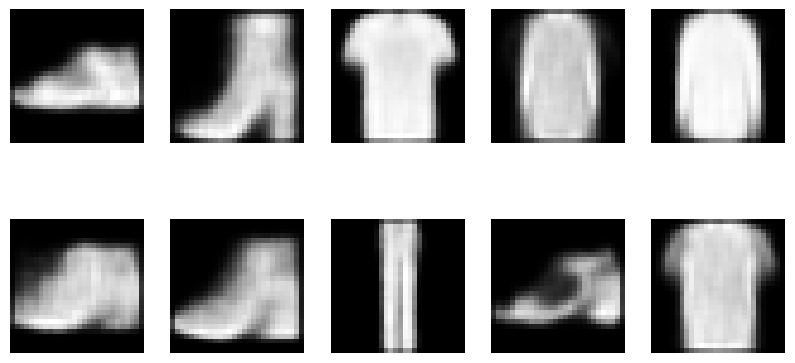

In [55]:
# Plot the generated images
plt.figure(figsize=(10, 5))
for i in range(generated_images.shape[0]):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

Above are 10 generated images

# **Experiment**

*1. Display latent space of mean for diffrent class*

In [ ]:
# Encode the test data into the latent space
z_mean, _, _ = encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


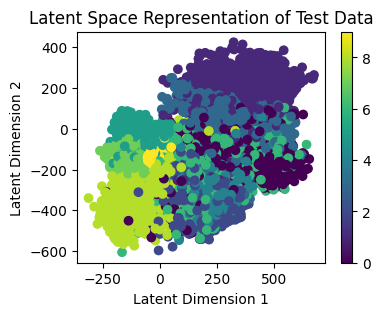

In [60]:
#(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()   ## If get erro y test not defined
plt.figure(figsize=(4,3))
plt.scatter(z_mean[:, 0], z_mean[:, 1],c=y_test, cmap='viridis')
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation of Test Data')
plt.show()


Above is graph of the 2D latent space of the Variational Autoencoder (VAE) after training on the Fashion MNIST dataset.


*   Each point in the scatter plot represents an image from the test set
*   The color of each point represents its actual clothing category label

Here ,
clusters of points with the same color are close to each others, it indicates that the VAE has learned to represent those clothing items (e.g., T-shirts) similarly in the latent space. This means that the VAE is able to encode similar types of images close to each other.



2. Display Orignal and reconstructed images

In [ ]:
def display_reconstructed_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ######
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        ######
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


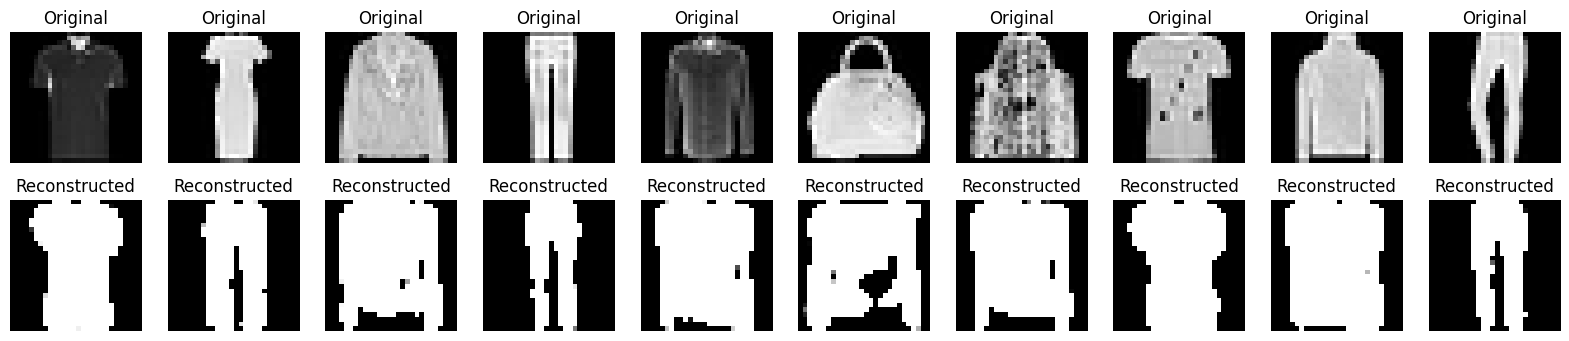

In [61]:
num_images = 10
random_indices = np.random.randint(0, x_test.shape[0], num_images)
original_images = x_test[random_indices]

### Pass images through VAE to reconstruct
reconstructed_images = vae.predict(original_images)

### Display
display_reconstructed_images(original_images, reconstructed_images, n=num_images)


More training time  and increasing complexity of model will help for better resuts